In [1]:
import os
import re
import sys
import itertools

import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import pandas as pd
from pandas.plotting import table
from sklearn.metrics import cohen_kappa_score as cks
from tabulate import tabulate

import imgkit
from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('precision', 2)

[Ipython Display](https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html)  
[imgkit](https://github.com/jarrekk/imgkit)  
[wkhtml2pdf](https://wkhtmltopdf.org/)  

### Reading the data from 1st and 2nd rounds

In [2]:
datapath = '../data/'
imagespath = '../data/Images/'

In [3]:
df_round1 = pd.read_hdf(os.path.join(datapath,'df_labeling.hdf'), key='round1')
df_round2 = pd.read_hdf(os.path.join(datapath,'df_labeling.hdf'), key='round2')

In [4]:
df_round1.user = df_round1.user.apply(lambda x:x + "1")
#df_round1.info()

In [5]:
df_round2.user = df_round2.user.apply(lambda x:x + "2")
#df_round2.info()

In [6]:
df = pd.concat([df_round1, df_round2])
df['id_image'] = pd.Categorical(df['image name']).codes
df = df[['round', 'task', 'user', 'id_image', 'class', 'image name']]
print(df['class'].unique())
print(len(df['id_image'].unique()))
#df.info()
df.head()

['Non-Fruits' 'Fruits' 'Informal' 'Formal' 'Appealing' 'Non-appealing']
392


,round,task,user,id_image,class,image name
0,1,1,Amelie1,87,Non-Fruits,203-resource_document_zuiderzeemuseum_B001601_...
1,1,1,Amelie1,232,Fruits,285-gam19649_1.jpeg
2,1,1,Amelie1,6,Fruits,07101-O_389_1.jpeg
3,1,1,Amelie1,12,Fruits,07101-O_927_1.jpeg
4,1,1,Amelie1,13,Non-Fruits,07101-O_957_1.jpeg


### Analysing the [inter-annotator agreement](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html) on the results

In [7]:
l1 = df.user.unique()
iter_users = list(itertools.product(l1,l1))

In [8]:
results = []
for task in df.task.unique():
    df_iaa = pd.DataFrame(index=l1, columns=l1)
    for user1,user2 in iter_users:
        classesA = df.loc[(df.user == user1) & (df.task == task),['id_image', 'class']]
        classesA.sort_values(by=['id_image'], inplace=True)

        classesB = df.loc[(df.user == user2) & (df.task == task),['id_image', 'class']]
        classesB.sort_values(by=['id_image'], inplace=True)
        
        classesAB = pd.merge(classesA, classesB, on=['id_image'])
        classesAB.drop_duplicates(subset='id_image', keep = 'first', inplace=True) 
        classesAB.drop('id_image', axis=1, inplace=True)
        classesAB.dropna(inplace=True)

        agreement = cks(classesAB['class_x'], classesAB['class_y'])
        #df_iaa.loc[user1,user2] = f'{agreement:.2f}/({len(classesAB)})'
        df_iaa.loc[user1,user2] = f'{agreement:.3f}'
        df_iaa = df_iaa.apply(pd.to_numeric)
        #df_iaa = df_iaa.applymap('{:,.2f}'.format)
        df_iaa.index.name = f'Task_{task}'
    results.append(df_iaa)
    #print(tabulate(df_iaa, headers='keys', tablefmt='psql'))
    #print()

In [9]:
cm = sns.light_palette("green", as_cmap=True)
cm = 'viridis'
cm = 'plasma'
cm = 'magma'
for task, df_task in enumerate(results):
    #s = df_task.style.applymap('{:,.2f}'.format)
    s = df_task.style.background_gradient(cmap=cm, vmin=0, vmax=1, axis=None)
    #s = df_task.style.highlight_max().format(None, na_rep="-")
    #s = df_task.style.background_gradient(cmap='viridis')
    display(s)
    html = s.render()
    imgkit.from_string(html, f'../data/styled_table{task+1}.png')

,Amelie1,Gerda1,Marcos1,Renato1,Yalemisew1,Amelie2,Gerda2,Marcos2,Renato2,Yalemisew2
Task_1,,,,,,,,,,
Amelie1,1.00,0.93,0.89,0.91,0.89,0.93,0.91,0.88,0.90,0.87
Gerda1,0.93,1.00,0.89,0.94,0.90,0.92,0.93,0.90,0.91,0.89
Marcos1,0.89,0.89,1.00,0.92,0.92,0.92,0.89,0.94,0.91,0.90
Renato1,0.91,0.94,0.92,1.00,0.92,0.93,0.90,0.92,0.94,0.91
Yalemisew1,0.89,0.90,0.92,0.92,1.00,0.93,0.88,0.92,0.91,0.92
Amelie2,0.93,0.92,0.92,0.93,0.93,1.00,0.94,0.91,0.93,0.91
Gerda2,0.91,0.93,0.89,0.90,0.88,0.94,1.00,0.89,0.91,0.87
Marcos2,0.88,0.90,0.94,0.92,0.92,0.91,0.89,1.00,0.92,0.93
Renato2,0.90,0.91,0.91,0.94,0.91,0.93,0.91,0.92,1.00,0.91


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


True

,Amelie1,Gerda1,Marcos1,Renato1,Yalemisew1,Amelie2,Gerda2,Marcos2,Renato2,Yalemisew2
Task_2,,,,,,,,,,
Amelie1,1.00,0.33,0.25,0.32,-0.09,0.18,-0.35,0.08,0.15,-0.12
Gerda1,0.33,1.00,0.21,0.31,0.15,0.32,-0.10,0.12,0.11,0.15
Marcos1,0.25,0.21,1.00,0.05,-0.03,-0.01,-0.31,0.10,-0.05,-0.04
Renato1,0.32,0.31,0.05,1.00,-0.03,0.29,-0.01,0.12,0.44,0.02
Yalemisew1,-0.09,0.15,-0.03,-0.03,1.00,0.05,0.21,0.12,-0.06,0.19
Amelie2,0.18,0.32,-0.01,0.29,0.05,1.00,0.17,0.22,0.26,0.17
Gerda2,-0.35,-0.10,-0.31,-0.01,0.21,0.17,1.00,0.19,0.10,0.42
Marcos2,0.08,0.12,0.10,0.12,0.12,0.22,0.19,1.00,0.09,0.36
Renato2,0.15,0.11,-0.05,0.44,-0.06,0.26,0.10,0.09,1.00,0.09


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


True

,Amelie1,Gerda1,Marcos1,Renato1,Yalemisew1,Amelie2,Gerda2,Marcos2,Renato2,Yalemisew2
Task_3,,,,,,,,,,
Amelie1,1.00,0.66,0.30,0.53,0.32,0.66,0.47,0.42,0.46,0.34
Gerda1,0.66,1.00,0.33,0.45,0.27,0.73,0.51,0.42,0.43,0.28
Marcos1,0.30,0.33,1.00,0.42,0.37,0.34,0.31,0.45,0.42,0.34
Renato1,0.53,0.45,0.42,1.00,0.45,0.54,0.57,0.41,0.69,0.45
Yalemisew1,0.32,0.27,0.37,0.45,1.00,0.31,0.40,0.32,0.44,0.67
Amelie2,0.66,0.73,0.34,0.54,0.31,1.00,0.47,0.40,0.53,0.34
Gerda2,0.47,0.51,0.31,0.57,0.40,0.47,1.00,0.35,0.56,0.45
Marcos2,0.42,0.42,0.45,0.41,0.32,0.40,0.35,1.00,0.33,0.35
Renato2,0.46,0.43,0.42,0.69,0.44,0.53,0.56,0.33,1.00,0.44


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


True

#### Using seaborn

In [10]:
#cm = 'viridis'
#cm = 'plasma'
#cm = 'magma'
#plt.subplots(figsize=(16,16))
#ax = sns.heatmap(df_task, annot=True, robust=True, cmap=cm)
#plt.savefig('../data/seaborn_heatmap.png')

### Measuring ambiguity of images

In [11]:
def showImagesHorizontally(files):
    fig = plt.figure(figsize=(18,16))
    number_of_files = len(files)
    for i in range(number_of_files):
        a = fig.add_subplot(1,number_of_files,i+1)
        image = imread(files[i])
        plt.imshow(image) #,cmap='Greys_r')
        plt.axis('off')

In [12]:
grouped = df.groupby(["task", "id_image", "class"]).agg("class").count()

### Ambiguous Images for task 1

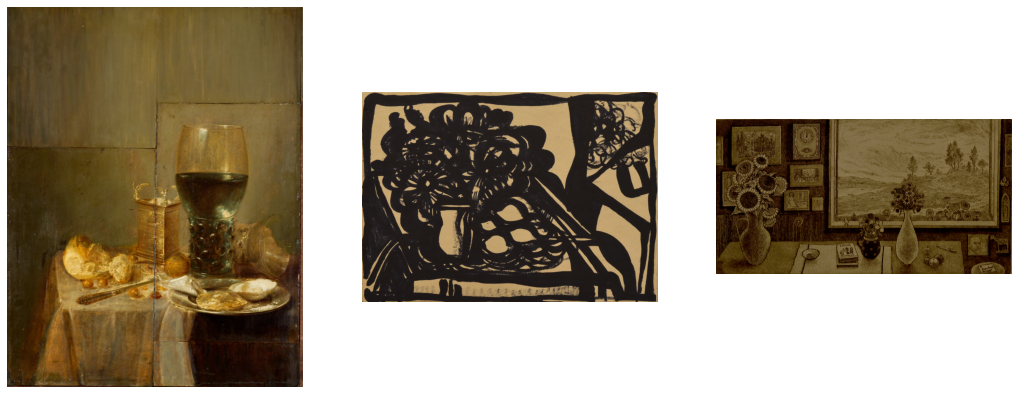

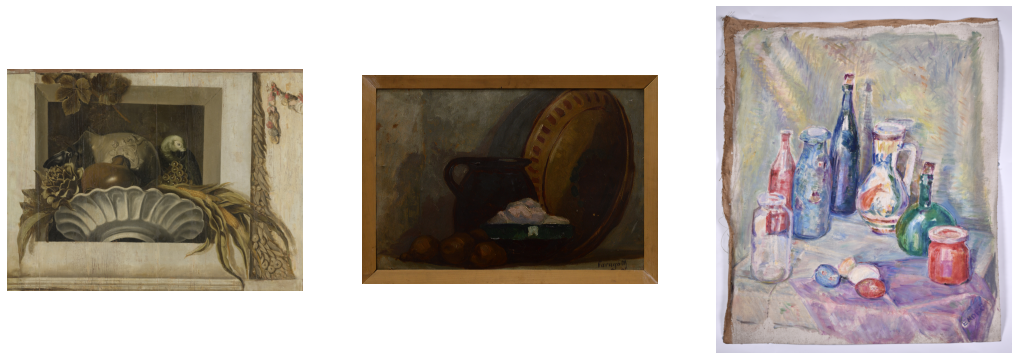

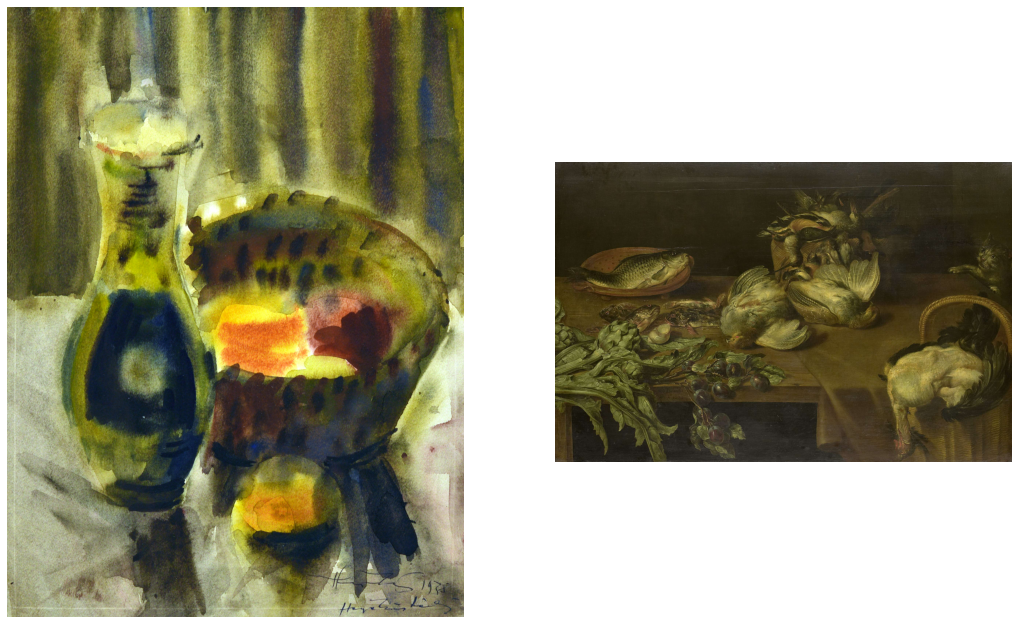

In [13]:
idx = pd.IndexSlice
ambiguous = grouped.loc[idx[[1]], (grouped>=4)&(grouped<=6)].index
ambiguous = list(set([y for (x,y,z) in ambiguous]))
list_of_files = list(set(df[(df.task==1)&(df.id_image.isin(ambiguous))]['image name']))
list_of_files = [os.path.join(imagespath, x) for x in list_of_files]
for idx2 in range(0,len(list_of_files),3):
    showImagesHorizontally(list_of_files[idx2:idx2+3])

### Ambiguous Images for task 2

In [ ]:
idx = pd.IndexSlice
ambiguous = grouped.loc[idx[[2]], (grouped>=4)&(grouped<=6)].index
ambiguous = list(set([y for (x,y,z) in ambiguous]))
list_of_files = list(set(df[(df.task==2)&(df.id_image.isin(ambiguous))]['image name']))
list_of_files = [os.path.join(imagespath, x) for x in list_of_files]
for idx2 in range(0,len(list_of_files),3):
    showImagesHorizontally(list_of_files[idx2:idx2+3])

<ipython-input-11-99fb82b84a30>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(18,16))


### Ambiguous Images for task 3

In [ ]:
idx = pd.IndexSlice
ambiguous = grouped.loc[idx[[3]], (grouped>=4)&(grouped<=6)].index
ambiguous = list(set([y for (x,y,z) in ambiguous]))
list_of_files = list(set(df[(df.task==3)&(df.id_image.isin(ambiguous))]['image name']))
list_of_files = [os.path.join(imagespath, x) for x in list_of_files]
for idx2 in range(0,len(list_of_files),3):
    showImagesHorizontally(list_of_files[idx2:idx2+3])